Siyu Wu Dec 10th


1.   bootstrap the train dataset after train test split, while kept the test untouched for valuation.
2.   bootstrap 20 models by adding guasian noise for train dataset



In [1]:
!pip install torchviz

In [2]:
# Import relevant python modules
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Loading data from txt file
# Change filename1 to another filename for data that extends to lower x
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)

# Splitting data randomly to train and test using the sklearn library
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

# Sort the split data according to their x values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

print("Data parsing is done!")

Data parsing is done!


In [51]:
print(df_train)
df_train.describe()

            x  gluon_cv  gluon_sd
0    0.001000  4.480675  0.523964
1    0.001007  4.478519  0.520743
2    0.001014  4.476361  0.517539
3    0.001021  4.474202  0.514349
4    0.001028  4.472040  0.511176
..        ...       ...       ...
993  0.952796 -0.001109  0.003990
994  0.959401 -0.000878  0.003423
996  0.972747 -0.000634  0.002707
997  0.979490 -0.000494  0.002179
999  0.993116 -0.000144  0.000697

[800 rows x 3 columns]


,x,gluon_cv,gluon_sd
count,800.000000,800.000000,800.000000
mean,0.142529,2.394590,0.126191
std,0.223498,1.562301,0.110767
min,0.001000,-0.003113,0.000697
25%,0.005312,0.725305,0.040385
50%,0.030236,2.819194,0.118667
75%,0.178136,3.832977,0.138032
max,0.993116,4.480675,0.523964


In [4]:
! pip install torchvision

In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

In [6]:
import torch.nn as nn
import torch.nn.functional as F


##################################################################
# Building NN from the PyTorch API (nn.Linear)
##################################################################

class Torch_Model(nn.Module):

    def __init__(self, n_features, n_neurons, n_outputs):

        super(Torch_Model, self).__init__()

        self.fc1 = nn.Linear(n_features, n_neurons) # Hidden Layer 1
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_neurons, n_outputs) # Output Layer

    # Evaluates and returns output
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
#set seed
torch.manual_seed(42)

In [9]:
# Hyperparameters
n_features = 1
n_neurons = 20
n_outputs = 1
learning_rate = 0.001
batch_size = 20
n_epochs = 1000

In [10]:
# Load data

#print(df_train.to_numpy())
#train_dataset, val_dataset = random_split(df_train.to_numpy(), [80, 20])

train_loader = DataLoader(df_train.to_numpy(), batch_size=batch_size)
val_loader = DataLoader(df_test.to_numpy(), batch_size=batch_size)



In [11]:
# Initialize network
model = Torch_Model(n_features, n_neurons, n_outputs).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y, dy):
        model.train()
        yhat = model(x)
        loss = loss_fn(y/dy, yhat/dy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare data
def prepare_data(df):
    # Normalize all `x` values
    mean = df['x'].mean()
    std = df['x'].std()
    df['x_normalized'] = (df['x'] - mean) / std
    #rename into train/test_data
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

    # prepare train, test both with normalization
    x_train = torch.tensor(train_data['x_normalized'].values.reshape(-1, 1)).float().to(device)
    y_train = torch.tensor(train_data['gluon_cv'].values.reshape(-1, 1)).float().to(device)
    dy_train = torch.tensor(train_data['gluon_sd'].values.reshape(-1, 1)).float().to(device)

    x_test = torch.tensor(test_data['x_normalized'].values.reshape(-1, 1)).float().to(device)
    y_test = torch.tensor(test_data['gluon_cv'].values.reshape(-1, 1)).float().to(device)
    dy_test = torch.tensor(test_data['gluon_sd'].values.reshape(-1, 1)).float().to(device)

    return x_train, y_train, dy_train, x_test, y_test, dy_test

x_train, y_train, dy_train, x_test, y_test, dy_test = prepare_data(df)

#bootstrap, sample the size = len(train) and adding guassian noise to the dataset.

def bootstrap_data_with_noise(x, y, dy, n_samples):
    indices = np.random.choice(range(len(x)), size=n_samples, replace=True)
    x_boot = x[indices]
    y_boot = y[indices]
    dy_boot = dy[indices]
    # Add Gaussian noise to the y values
    y_boot_noisy = y_boot + torch.normal(mean=0, std=dy_boot)
    return x_boot, y_boot_noisy, dy_boot

# Create 20 bootstrapped train datasets with noise added
bootstrapped_datasets = [bootstrap_data_with_noise(x_train, y_train, dy_train, len(x_train)) for _ in range(20)]


# Create data loaders
train_dataset = TensorDataset(x_train, y_train, dy_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(x_test, y_test, dy_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Normalize Batch by : x_batch_normalized = (x_batch - mean) / std
Then calculate loss: loss = train_step(x_batch_normalized, y_batch, dy_batch)

In [15]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# list to hold all trained models
models = []

# Training loop
train_losses = []
test_losses = []

# Training models on bootstrapped train data
for i, (x_boot, y_boot_noisy, dy_boot) in enumerate(bootstrapped_datasets):
    model = Torch_Model(n_features, n_neurons, n_outputs).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_dataset = TensorDataset(x_boot, y_boot_noisy, dy_boot)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    for epoch in range(n_epochs):
        train_loss = 0
        model.train()
        for x_batch, y_batch, dy_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_batch / dy_batch, y_pred / dy_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on the test set
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x_batch, y_batch, dy_batch in test_loader:
                y_pred = model(x_batch)
                loss = criterion(y_batch / dy_batch, y_pred / dy_batch)
                test_loss += loss.item()

            test_loss /= len(test_loader)
            test_losses.append(test_loss)

        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Save the model after all epochs for this bootstrap are complete
    model_save_path = os.path.join(f'replica{i+1}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')

    # Append the model to the models list
    models.append(model)


Epoch [100/1000], Train Loss: 8.1746, Test Loss: 22.4076
Epoch [200/1000], Train Loss: 24.0481, Test Loss: 25.3119
Epoch [300/1000], Train Loss: 3.2692, Test Loss: 3.9767
Epoch [400/1000], Train Loss: 4.0604, Test Loss: 16.5685
Epoch [500/1000], Train Loss: 7.7734, Test Loss: 27.9898
Epoch [600/1000], Train Loss: 19.1628, Test Loss: 17.1935
Epoch [700/1000], Train Loss: 3.2357, Test Loss: 1.7839
Epoch [800/1000], Train Loss: 3.4189, Test Loss: 4.7516
Epoch [900/1000], Train Loss: 3.6518, Test Loss: 5.3197
Epoch [1000/1000], Train Loss: 3.2894, Test Loss: 13.0519
Model saved to replica1.pth
Epoch [100/1000], Train Loss: 5.2470, Test Loss: 4.2589
Epoch [200/1000], Train Loss: 3.0187, Test Loss: 2.2232
Epoch [300/1000], Train Loss: 2.7351, Test Loss: 2.0105
Epoch [400/1000], Train Loss: 2.5174, Test Loss: 1.7205
Epoch [500/1000], Train Loss: 2.4116, Test Loss: 1.5304
Epoch [600/1000], Train Loss: 2.1531, Test Loss: 1.2696
Epoch [700/1000], Train Loss: 2.1058, Test Loss: 1.2522
Epoch [800/

In [21]:
import torch
import numpy as np
#print out the predictons for 20 bootstraped models comapread to the y_test

all_predictions = []

for model in models:
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
        all_predictions.append(y_pred.cpu().numpy())
all_predictions = np.array(all_predictions)

# Print the predictions
print("All predictions from each model:")
print(all_predictions)
print("Shape of the predictions array:", all_predictions.shape)

All predictions from each model:
[[[2.8405757 ]
  [0.9073755 ]
  [0.8812885 ]
  ...
  [3.7282217 ]
  [1.9498484 ]
  [3.7966309 ]]

 [[2.5784018 ]
  [0.82891566]
  [0.8119356 ]
  ...
  [3.9059057 ]
  [2.0284328 ]
  [4.036018  ]]

 [[2.6800077 ]
  [0.87477154]
  [0.84946495]
  ...
  [3.9264712 ]
  [2.0370934 ]
  [4.072608  ]]

 ...

 [[2.6688712 ]
  [0.86218923]
  [0.84165746]
  ...
  [3.9390423 ]
  [2.0498228 ]
  [4.0950456 ]]

 [[2.687024  ]
  [0.8210387 ]
  [0.7864766 ]
  ...
  [3.944383  ]
  [2.0100052 ]
  [4.1054688 ]]

 [[2.7115495 ]
  [0.8006524 ]
  [0.76513207]
  ...
  [3.9503458 ]
  [1.9717087 ]
  [4.1243916 ]]]
Shape of the predictions array: (20, 200, 1)


In [34]:
#calculate the mean std of predicitons
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)
print(mean_predictions)
print(std_predictions)

[[2.6805587 ]
 [0.8339669 ]
 [0.8115662 ]
 [1.5371385 ]
 [3.2060738 ]
 [1.3426971 ]
 [1.8871241 ]
 [2.7241604 ]
 [0.16376802]
 [4.0424547 ]
 [0.36239362]
 [4.1039925 ]
 [1.7848822 ]
 [0.00605463]
 [0.02133008]
 [0.08263341]
 [3.7333202 ]
 [0.11323114]
 [0.65917337]
 [3.5993629 ]
 [2.516917  ]
 [3.9879966 ]
 [3.3974576 ]
 [2.6472416 ]
 [3.9214008 ]
 [3.8643842 ]
 [4.0814147 ]
 [0.00555702]
 [0.07680344]
 [0.01506143]
 [3.4993978 ]
 [4.038656  ]
 [1.9357065 ]
 [2.7953331 ]
 [3.4017708 ]
 [3.9454627 ]
 [1.248064  ]
 [2.2648456 ]
 [0.07876019]
 [4.117258  ]
 [3.5670476 ]
 [4.0862484 ]
 [3.6237855 ]
 [0.00596411]
 [3.6680114 ]
 [3.7433808 ]
 [0.03814935]
 [2.1188886 ]
 [3.0669796 ]
 [0.24859318]
 [2.3730578 ]
 [0.12067787]
 [3.793658  ]
 [2.3125432 ]
 [4.1406913 ]
 [4.136579  ]
 [1.9735597 ]
 [4.14782   ]
 [3.8975215 ]
 [0.32324964]
 [3.6780972 ]
 [4.1208715 ]
 [2.56043   ]
 [3.9234836 ]
 [2.092005  ]
 [1.1952347 ]
 [1.5165988 ]
 [0.14466825]
 [4.1088533 ]
 [2.5543425 ]
 [4.075388  ]
 [2.82

In [38]:
import torch
x_test_np = x_test.cpu().numpy().flatten()
y_test_np = y_test.cpu().numpy().flatten()

# Get the sorted indices from x_test
sorted_indices = x_test_np.argsort()
# Apply the sorted indices to x_test, mean_predictions, std_predictions, and y_test
x_test_sorted = x_test_np[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]
y_test_sorted = y_test_np[sorted_indices]

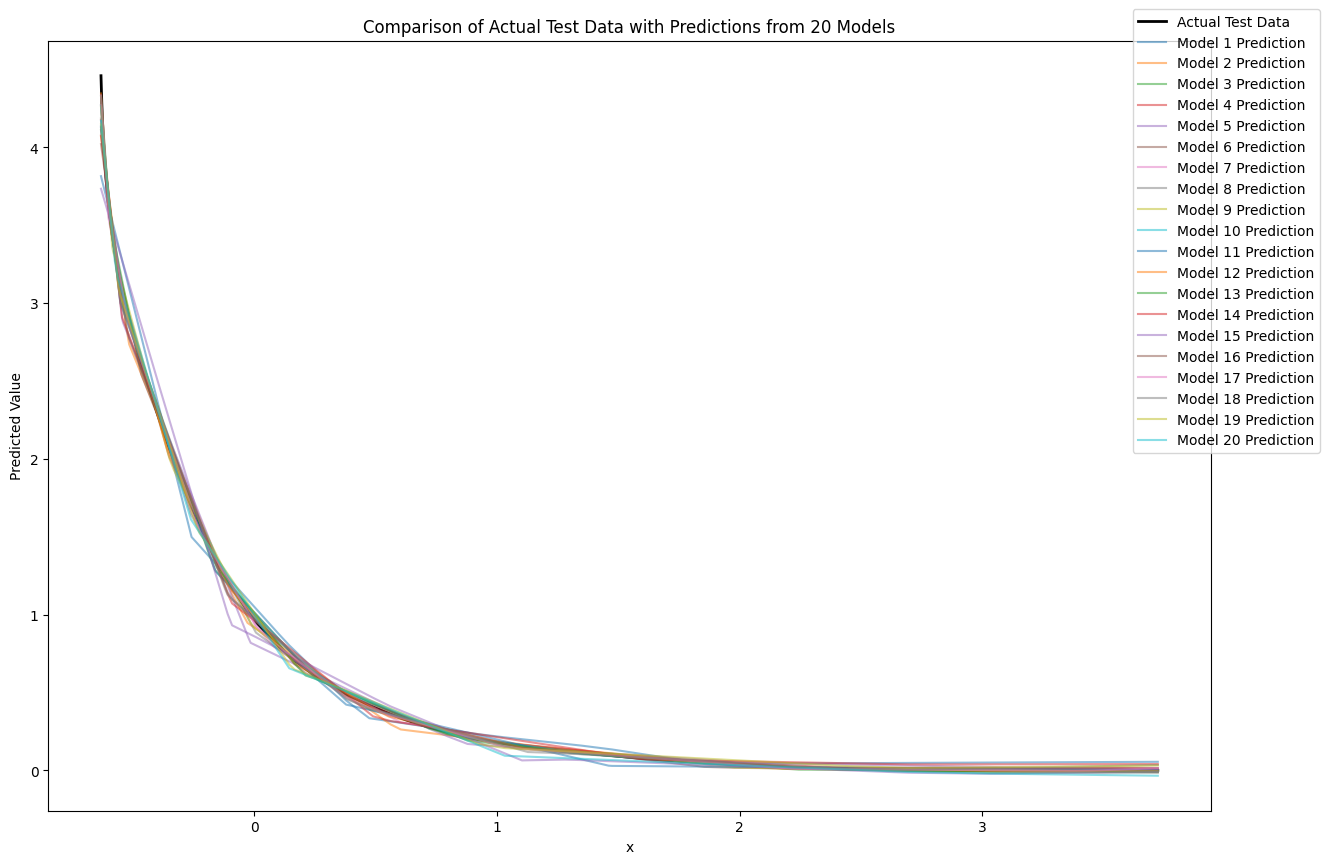

In [46]:
#plot bootstrapped models' y_predictions and the validation y_prediciton.
import matplotlib.pyplot as plt
import torch
import numpy as np

if isinstance(y_test, torch.Tensor):
    y_test_np = y_test.cpu().numpy()
else:
    y_test_np = y_test

x_test_np = x_test.cpu().numpy() if isinstance(x_test, torch.Tensor) else x_test
sorted_indices = np.argsort(x_test_np.flatten())
x_test_sorted = x_test_np.flatten()[sorted_indices]
y_test_sorted = y_test_np.flatten()[sorted_indices]


plt.figure(figsize=(15, 10))

x_test_sorted = np.squeeze(x_test_sorted)
y_test_sorted = np.squeeze(y_test_sorted)

# Plot the actual test data
plt.plot(x_test_sorted, y_test_sorted, label='Actual Test Data', color='black', linewidth=2)

# Plot sorted predictions from each model
for i, predictions in enumerate(all_predictions):
    sorted_predictions = predictions.flatten()[sorted_indices]
    plt.plot(x_test_sorted, sorted_predictions, label=f'Model {i+1} Prediction', alpha=0.5)

plt.title('Comparison of Actual Test Data with Predictions from 20 Models')
plt.xlabel('x')
plt.ylabel('Predicted Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))  # Adjust legend outside the plot to reduce clutter
plt.show()


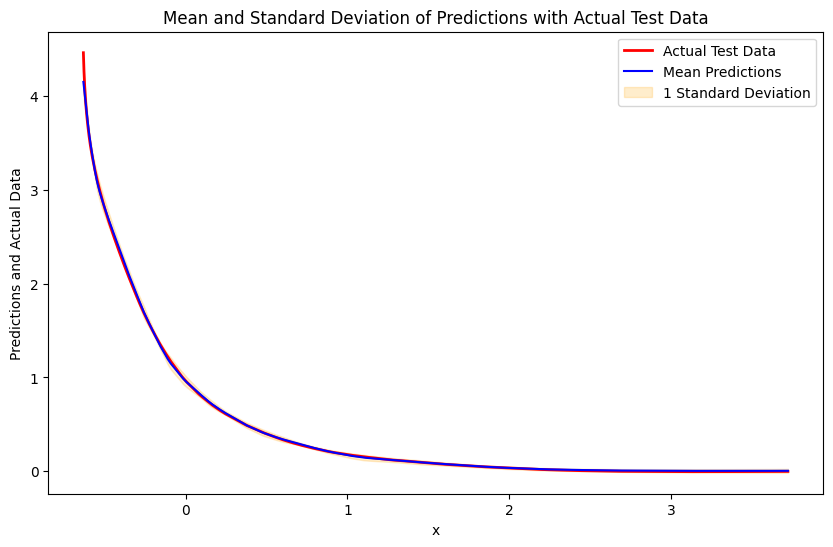

In [50]:
#plot validation y_test with "ensembled" models' prediciton (expressed with mean_prediciton with std)
mean_predictions_sorted = mean_predictions_sorted.flatten()
std_predictions_sorted = std_predictions_sorted.flatten()

plt.figure(figsize=(10, 6))

# Plot the actual test data
plt.plot(x_test_sorted, y_test_sorted, label='Actual Test Data', color='red', linewidth=2)

# Plot the mean predictions
plt.plot(x_test_sorted, mean_predictions_sorted, label='Mean Predictions', color='blue')

# Fill between for standard deviation interval
plt.fill_between(x_test_sorted,
                 mean_predictions_sorted - std_predictions_sorted,
                 mean_predictions_sorted + std_predictions_sorted,
                 color='orange', alpha=0.2, label='1 Standard Deviation')

plt.xlabel('x')
plt.ylabel('Predictions and Actual Data')
plt.title('Mean and Standard Deviation of Predictions with Actual Test Data')
plt.legend()
plt.show()

